## Section 1

You can use the implementation described in https://keras.io/examples/vision/grad_cam/ for section 1 of problem 2.

In [1]:
import tensorflow
print(tensorflow.__version__)

2.8.0


## Import Libraries and load cifar10 dataset.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Define Helper functions

In [3]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    print("preds shape: ", np.shape(preds))
    print("Class_channel shape: ", np.shape(class_channel))
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print("grads shape: ", np.shape(grads))
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    print("last_conv_layer_output shape: ", np.shape(last_conv_layer_output))

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

def build_model():
    #TODO: Create Model with model_builder(weights="imagenet"), remove last layer's softmax and return model.
    model = model_builder(weights="imagenet")
    
    # Remove last layer's softmax
    model.layers[-1].activation = None
    
    return model
  

def plot_heatmap(heatmap):
    # TODO: Display heatmap
    # Display heatmap
    plt.matshow(heatmap)
    plt.show()


### Define Configurable parameters 

81920/69762 [===================================] - 0s 2us/step


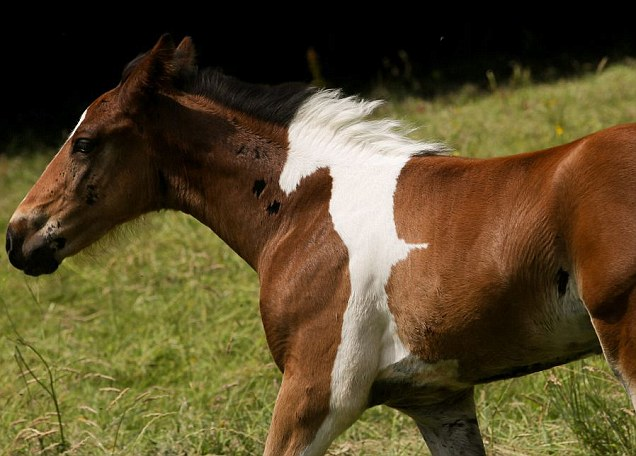

In [4]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image (Do not pick one from CIFAR-10 dataset. Pick any other high-resolution image from internet)
img_path = keras.utils.get_file(
    "horse1.jpg",  "https://i.imgur.com/CLu1Svx.jpeg"
)

display(Image(img_path))


### Test Grad CAM on desired image

Image_array: (1, 299, 299, 3)
(1, 1000)
Predicted: [('n02389026', 'sorrel', 9.019721)]
preds shape:  (1, 1000)
Class_channel shape:  (1,)
grads shape:  (1, 10, 10, 2048)
last_conv_layer_output shape:  (10, 10, 2048)


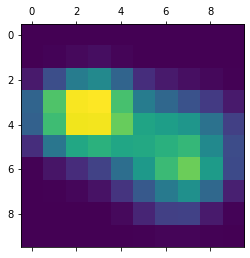

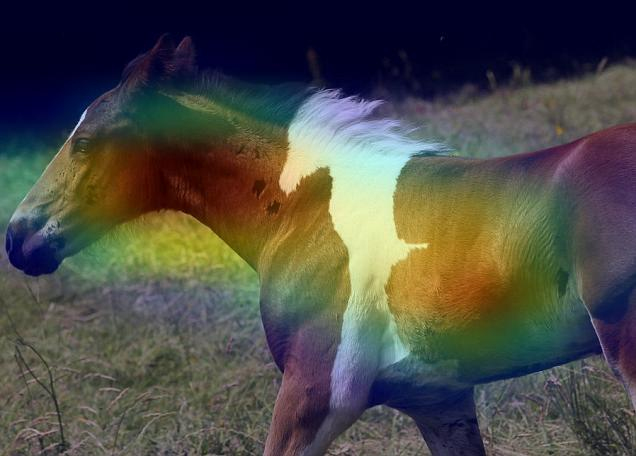

In [ ]:


#Step 1 Preprocess image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print("Image_array:" ,np.shape(img_array))

#Step 2 Create model and predict img array
model = build_model()
# Print what the top predicted class is
preds = model.predict(img_array)
print(np.shape(preds))
print("Predicted:", decode_predictions(preds, top=1)[0])

# Step 3 Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


#Step 4 Plot heatmap 
plot_heatmap(heatmap)

#Step 5 Display gradcam with image path and heatmap.
save_and_display_gradcam(img_path, heatmap)

# Grad-CAM on my-CNN 

In [ ]:
!unzip my_cifar_cnn_model.zip

Archive:  my_cifar_cnn_model.zip
replace my_cifar_cnn_model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls 


my_cifar_cnn_model_b32.h5  sample_data


In [3]:
!pip install tensorflow_ranking

     |████████████████████████████████| 141 kB 6.0 MB/s 
     |████████████████████████████████| 462 kB 48.3 MB/s 


In [5]:
# Import the necessary model
from keras.models import load_model

from tensorflow_ranking.python.keras.metrics import MeanAveragePrecisionMetric

my_CNN_model = keras.models.load_model("my_cifar_cnn_model_b32.h5", custom_objects={'MeanAveragePrecisionMetric':MeanAveragePrecisionMetric})
# my_CNN_model = keras.models.load_model("my_cifar_cnn_model_2.h5")


print(my_CNN_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [39]:
img_size = (32, 32)

#Step 1 Preprocess image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print(np.shape(img_array))

# Print what the top predicted class is
preds = my_CNN_model.predict(img_array,batch_size = 8)

print(np.shape(preds))
print(preds)
# print("Predicted:", decode_predictions(preds, top=1)[0])


(1, 32, 32, 3)
(1, 10)
[[4.9112568e-06 3.7768413e-04 3.1353680e-03 4.8502381e-03 3.4383957e-05
  1.7838954e-03 9.3730587e-01 5.1736820e-02 3.1804220e-08 7.7086774e-04]]


preds shape:  (1, 10)
Class_channel shape:  (1,)
grads shape:  (1, 4, 4, 128)
last_conv_layer_output shape:  (4, 4, 128)


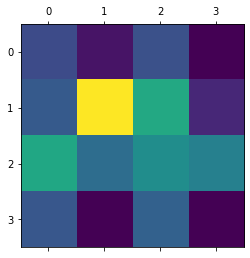

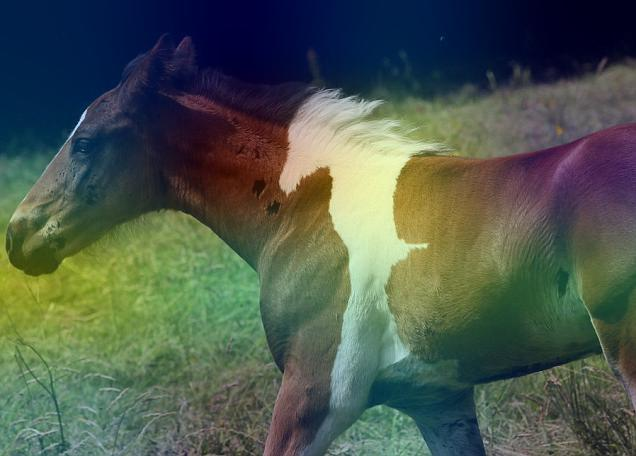

In [ ]:
# Selecting the last convolutional layer (the one before flatten())
last_conv_layer_name = 'dropout_12'


# Step 3 Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, my_CNN_model, last_conv_layer_name)


#Step 4 Plot heatmap 
plot_heatmap(heatmap)

#Step 5 Display gradcam with image path and heatmap.
save_and_display_gradcam(img_path, heatmap)

# Section 2

TODO: Please refer to https://github.com/tensorflow/tcav to use TCAV. This repository has an example on using TCAV on Jupyter notebook as well -- https://github.com/tensorflow/tcav/blob/master/Run_TCAV_on_colab.ipynb

Typical interpretability methods require you to have one particular image that you are interested in understanding. TCAV gives an explanation that is generally true for a class of interest, beyond one image (global explanation).

For example, for a given class, we can show how much race or gender was important for classifications in InceptionV3. Even though neither race nor gender labels were part of the training input!

In [2]:
!git clone https://github.com/pnxenopoulos/cav-keras.git
!cp -R cav-keras/cav cav/

fatal: destination path 'cav-keras' already exists and is not an empty directory.


In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.datasets import cifar100, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from cav.tcav import *

np.random.seed(1996)

170508288/170498071 [==============================] - 3s 0us/step


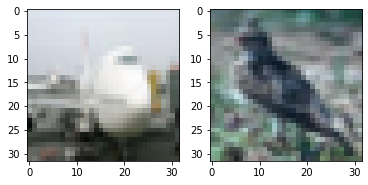

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Keep airplanes (0) from CIFAR-10
interested_class = y_train == [0]

interested_class_indx = [i for i, x in enumerate(interested_class) if x]
x_train_class_one = x_train[interested_class_indx]

#random images (birds)
other = y_train == [2]
other_indx = [i for i, x in enumerate(other) if x]
x_train_class_two = x_train[other_indx]

x_train = np.append(x_train_class_one, x_train_class_two, axis = 0)
y_train = [0] * 5000
y_train = y_train + [1] * 5000

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[11])
axarr[1].imshow(x_train[7777])

Now, let's say we are interested in how sensitive each class is to the concept of the "cloud". Clearly, the airplanes class, which we designate as 1, will likely be more sensitive.

In [9]:
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

# keep cloud (23) from CIFAR-100
concept = y_train_concept == [23]
indices = concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]

169017344/169001437 [==============================] - 3s 0us/step


Now, we instantiate the TCAV object. The first thing one should do when using TCAV is assign it a model.

In [10]:
tcav_obj = TCAV()
tcav_obj.set_model(my_CNN_model)

Next, we must specify the "bottleneck" layer, and if that layer is a convolutional layer. One can split the model in the object through the .split_model(bottleneck, conv_layer) method. 

Next, we calculate the sensitivities for our training data through the .calculate_sensitivity(x_train, y_labels) method.  This will require a bit more RAM.

Finally, to print the sensitivities, simply use the .print_sensitivity() method.

In [11]:
tcav_obj.split_model(bottleneck = 1, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

RuntimeError: ignored

In [ ]:
tcav_obj.split_model(bottleneck = 7, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

In [ ]:
tcav_obj.split_model(bottleneck = 9, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

In [ ]:
tcav_obj.split_model(bottleneck = 15, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

In [ ]:
tcav_obj.split_model(bottleneck = 17, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

In [ ]:
tcav_obj.split_model(bottleneck = 23, conv_layer = True)
tcav_obj.train_cav(x_train_concept)
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

# Conclusions